In [174]:
import io
import json
from math import sqrt, ceil
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing, tree
from graphviz import Source

from sklearn.ensemble import RandomForestRegressor

from time import time
from os import system

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
DATA_PATH = '/content/drive/Shareddrives/DriveLaVoitureHAHA/notreIATM/dataset/train_races_mid'
MODEL_PATH = '/content/drive/Shareddrives/DriveLaVoitureHAHA/notreIATM/model/drive'

In [159]:
class Dataset():
    def __init__(self, data_path):
        self.data_path = data_path
        self.dataset_folder_path = data_path + '../../../'
        self.COLUMNS = ['wall0','wall1','wall2','wall3','wall4','wall5','wall6','wall7','wall8','wall9','wall10','wall11','wall12','wall13','speed','turn','go_forward','go_backward']

        with io.open(data_path + '/config.json') as config_file:
            self.config = json.loads(config_file.read())

        with io.open(data_path + '/dataRaw.json') as dataraw_file:
            self.dataraw = [Dataraw(data) for data in json.loads(dataraw_file.read())]

        with io.open(data_path + '/dataset.json') as dataset_file:
            self.framedata = [Framedata(data) for data in json.loads(dataset_file.read())]
        self.framedata_df = self.framedata_to_dataframe()

            
    def display_images(self, lower=0, upper=None, padding=1):
        if upper is None:
            upper = len(self.dataraw)
        n_img = [self.dataset_folder_path + dataraw['imgFilename'] for dataraw in self.dataraw[lower:upper:padding]]
        m = ceil(sqrt(len(n_img)))
        fig, ax = plt.subplots(m, m, figsize=(16,16))
        for i in range(len(n_img)):
            ax = plt.subplot(m, m, i+1)
            ax.set_title(f"Frame {i+1} {n_img[i].split('/')[-1].split('.')[0]}", fontsize=12)
            img_path = n_img[i]
            img = imread(img_path)
            plt.imshow(img)
        plt.plot()
        
    def framedata_to_dataframe(self):
        df = pd.DataFrame([f.to_list() for f in self.framedata], columns=self.COLUMNS)
        df = d.framedata_df.dropna()
        return df

    def get_X_y(self):
        X = self.framedata_df.loc[:,d.COLUMNS[:15]]
        y = self.framedata_df.loc[:,d.COLUMNS[-3:]]
        return (X, y)
      
class Dataraw():
    def __init__(self, jsonData):
        self.imgFilename = jsonData['imgFilename']
        self.target = jsonData['target']
    
    def __repr__(self):
        return f'Dataraw(imgFilename={self.imgFilename}, target={self.target})'

class Framedata():
    def __init__(self, jsonData):
        self.wallDistances = jsonData['wallDistances']
        self.speed = jsonData['speed']
        self.target = jsonData['target']
    
    def __repr__(self):
        return f'Framedata(wallDistances={self.wallDistances}, speed={self.speed}, target={self.target})'
    
    def to_list(self):
        return self.wallDistances + [self.speed] + self.target
        

In [162]:
d = Dataset(DATA_PATH)
d.framedata_df

,wall0,wall1,wall2,wall3,wall4,wall5,wall6,wall7,wall8,wall9,wall10,wall11,wall12,wall13,speed,turn,go_forward,go_backward
0,448,377,339,296.0,280.0,263.0,261.0,260.0,262.0,279.0,296.0,337.0,374.0,440.0,12.0,0.08,1.0,0.0
1,440,374,337,296.0,279.0,262.0,260.0,261.0,263.0,280.0,296.0,339.0,377.0,448.0,12.0,-0.08,1.0,0.0
2,446,377,337,295.0,279.0,262.0,260.0,260.0,261.0,278.0,295.0,335.0,372.0,437.0,15.0,0.08,1.0,0.0
3,437,372,335,295.0,278.0,261.0,260.0,260.0,262.0,279.0,295.0,337.0,377.0,446.0,15.0,-0.08,1.0,0.0
4,446,375,337,296.0,280.0,263.0,260.0,259.0,261.0,278.0,295.0,335.0,370.0,436.0,19.0,0.08,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22105,451,382,341,297.0,280.0,259.0,256.0,258.0,265.0,298.0,320.0,375.0,390.0,457.0,209.0,1.00,1.0,0.0
22106,454,387,374,319.0,296.0,271.0,260.0,256.0,259.0,279.0,298.0,343.0,383.0,454.0,210.0,-1.00,1.0,0.0
22107,454,383,343,298.0,279.0,259.0,256.0,260.0,271.0,296.0,319.0,374.0,387.0,454.0,210.0,1.00,1.0,0.0
22108,446,387,347,304.0,286.0,265.0,262.0,263.0,268.0,292.0,314.0,347.0,387.0,457.0,0.0,-1.00,0.0,0.0


(540, 960, 3)


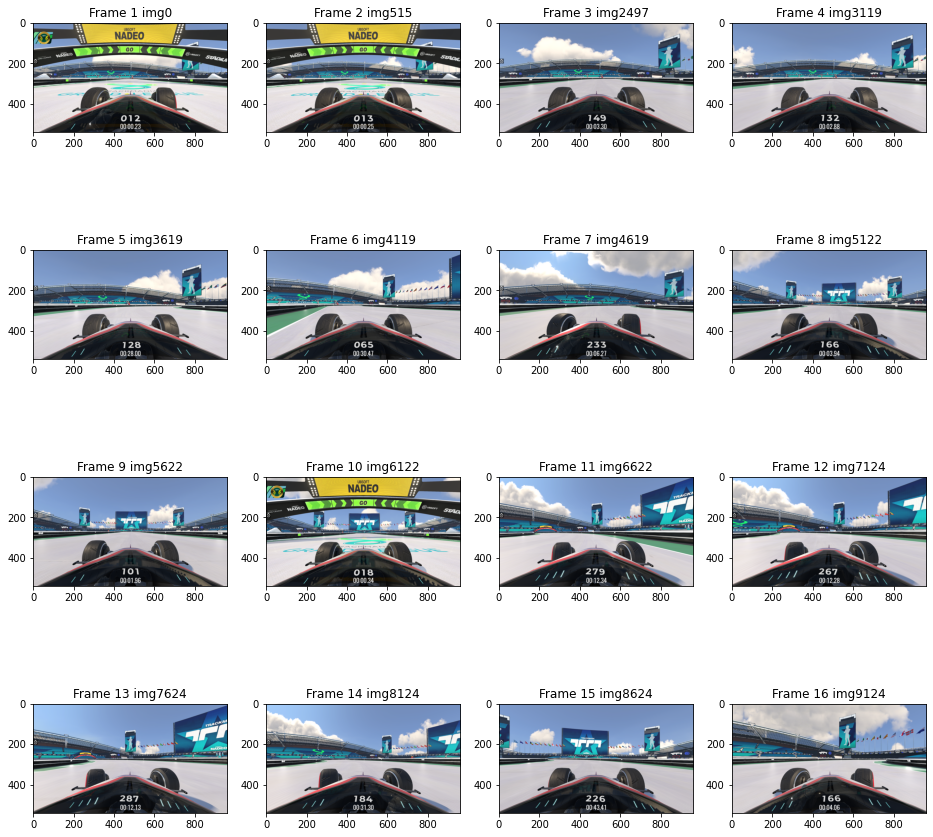

In [96]:
d.display_images(0,8000,500)
n_img = [d.dataset_folder_path + dataraw['imgFilename'] for dataraw in d.dataraw[:1]]
print(imread(n_img[0]).shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


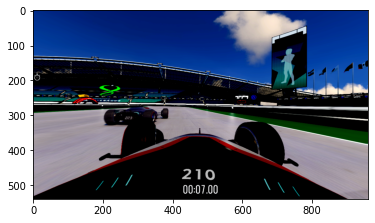

In [76]:
i = imread(d.dataset_folder_path + d.dataraw[279]['imgFilename'])
i = i / 127 - 1
plt.imshow(i)

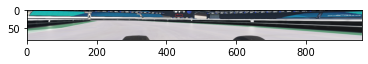

In [91]:
i = imread(d.dataset_folder_path + d.dataraw[270]['imgFilename'])
i = i[245:]
i = i[:85]
plt.imshow(i)

## Preprocessing

In [78]:
d = Dataset(DATA_PATH)
X, y = d.get_X_y()

# scaler = preprocessing.StandardScaler().fit(X)
# X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

## Create and train a random forest model

In [47]:
SEED = 0

random_forest = RandomForestRegressor()

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

random_forest_tuning = RandomForestRegressor(random_state = SEED)
param_grid = {
   'n_estimators': [100],
   'max_features': ['auto'],
   'max_depth' : [None],
   'criterion' : ['mse']
}
# 1000 > 500 > 100
# auto > log2 & sqrt
# None > 8 > 7 > 4
# mse > mae
GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
GSCV.fit(X_train, y_train)
GSCV.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

{'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 100}

In [79]:
y_test

,turn,go_forward,go_backward
20529,-0.00,1.0,0.0
10993,1.00,1.0,0.0
16624,0.06,1.0,0.0
6696,-0.46,1.0,0.0
15786,1.00,1.0,0.0
...,...,...,...
12029,0.89,1.0,0.0
1803,0.21,1.0,0.0
2534,0.05,1.0,0.0
5293,-0.08,1.0,0.0


In [80]:
X_test['speed'].values.size

8207

In [81]:
y_test['turn'].size

8207

In [82]:
y_test

,turn,go_forward,go_backward
20529,-0.00,1.0,0.0
10993,1.00,1.0,0.0
16624,0.06,1.0,0.0
6696,-0.46,1.0,0.0
15786,1.00,1.0,0.0
...,...,...,...
12029,0.89,1.0,0.0
1803,0.21,1.0,0.0
2534,0.05,1.0,0.0
5293,-0.08,1.0,0.0


Train took 9.10s
Predict took 0.20s
MAE base:  0.09502522543952789
MSE base:  0.045143929820491646


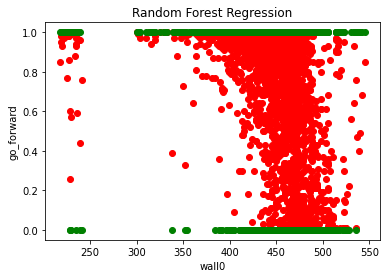

In [84]:
test_new_rf = False
if test_new_rf:
    random_forest = RandomForestRegressor(random_state = SEED,
        # criterion='mse',
        max_depth=8,
        n_estimators=100,
        # max_features='auto'
        )
    start = time()
    random_forest.fit(X_train, y_train)
    print(f"Train took {time() - start:.2f}s")

    start = time()
    y_pred = random_forest.predict(X_test)
    print(f"Predict took {time() - start:.2f}s")

    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred)) 
    

random_forest_base = RandomForestRegressor()

start = time()
random_forest_base.fit(X_train, y_train)
print(f"Train took {time() - start:.2f}s")

start = time()
y_pred_base = random_forest_base.predict(X_test)
print(f"Predict took {time() - start:.2f}s")

print('MAE base: ', mean_absolute_error(y_test, y_pred_base))
print('MSE base: ', mean_squared_error(y_test, y_pred_base)) 


X_field = 'wall0'
y_field = 'go_forward'
y_field_index = 1

plt.scatter(X_test[X_field].values, [row[y_field_index] for row in y_pred_base], color = 'red')
plt.scatter(X_test[X_field].values, y_test[y_field].values, color = 'green')
plt.title('Random Forest Regression')
plt.xlabel(X_field)
plt.ylabel(y_field)
plt.show() 

In [86]:
dtree = random_forest_base.estimators_[0]
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=X.columns))
graph.format = 'png'
graph.render('dtree_render',view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.17288 to fit


'dtree_render.png'

## Save the random forest model

In [87]:
from joblib import dump, load
dump(random_forest_base, MODEL_PATH + '/random_forest_big_uncropped.joblib')

['/content/drive/Shareddrives/DriveLaVoitureHAHA/notreIATM/model/drive/random_forest_big_uncropped.joblib']

In [178]:
rf = load(MODEL_PATH + '/random_forest_uncropped.joblib')

In [179]:
rf.predict([[460, 389, 347, 304, 287, 270, 267, 268, 269, 287, 304, 347, 383, 454, 0]])

array([[0.05526381, 1.        , 0.        ]])

In [180]:
rf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.4687122482902831